# Assignment 01: Plotting Cost Landscapes



In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA
from openqaoa.problems.problem import QUBO, MaximumCut
from openqaoa.devices import create_device

In [2]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)



### Task 1: Build a function to generate p=1 analytical landscapes using the expectation value functions in utilies of OQ.

Plot the landscapes of four instances, e.g. w3R (weighted 3-regular graphs) with $n = 12$ qubits, with normally distributed weights, for $\mu = 0$ and $\sigma = 0.1, 1, 10, 100$.

Note: A regular graph is a graph where each vertex has the same number of neighbours (edges) 3 in this case. Weighted means that every edge is given a value (weight). 

In [3]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [5]:
def random_classical_hamiltonian_normal_distribution(reg: List[int],
                                 seed: int = None,
                                 weighted: bool = True,
                                 mu: float = 0.0, 
                                 sigma: float = 1.0,
                                 biases: bool = True,
                                 constant: int = 0) -> Hamiltonian:
    
    # Set the random seed
    np.random.seed(seed=seed)

    # Initialize terms and weights
    terms = []
    weights = []

    
    # Generate quiadratic terms, scanning all possible combinations
    for q1, q2 in itertools.combinations(reg, 2):

        # Choose at random to couple terms
        are_coupled = np.random.randint(2)

        # If coupled, generate coefficients and store along with term
        ############################ CHANGED HERE ############################
        if are_coupled:
            couple_coeff = np.random.normal(mu, sigma) if weighted else 1
            terms.append([q1, q2])
            weights.append(couple_coeff)
        #######################################################################

    # Ensure each term has an associated weight
    assert len(terms) == len(
        weights), "Each term should have an associated weight"

    # Define classical Hamiltonian
    hamiltonian = Hamiltonian.classical_hamiltonian(
        terms, weights, constant=constant)
    
    qubo = QUBO(len(reg),terms,weights)

    return hamiltonian, qubo


In [6]:
# helper function to produce the cost landscape
def create_cost_landscape_std(hamiltonian, gammas, betas):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    """
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
           
    return cost_landscape

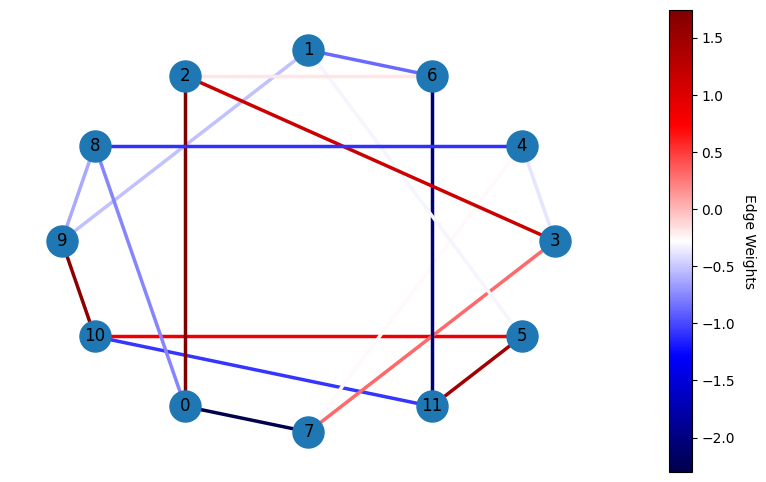

In [21]:

# Define problem size
n = 12

sigma=1

# Define 3wR graph and plot it
g = random_k_regular_graph_normal_distribution(degree=3, nodes=range(n), seed=1, weighted=True, mu=0.0, sigma=sigma, biases=False)
plot_graph(g)

# Define te problem and translate itinto a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()

# Define Hamiltonian
cost_hamiltonian = hamiltonian_from_graph(g)

# Define rest of the problem and circuit
qubit_register = range(n)
pauli_coeffs = [1]*n
mixer_hamiltonian = X_mixer_hamiltonian(n, pauli_coeffs)

# Define QAOA Circuit Parameters with p=1
circuit_params = QAOACircuitParams(cost_hamiltonian, mixer_hamiltonian, p=1)

variate_params_std = create_qaoa_variational_params(circuit_params,'standard','ramp')



Evaluate `expectation` value to construct the cost landscapes for both the parameterizations. For this purpose, we define a helper function that computes the value of each pair of angles on the grid, ($\beta_0, \gamma_0$) for StandardParams

In [22]:
gammas = np.linspace(0, 10*np.pi, 100)
betas = np.linspace(0, np.pi/2, 100)

cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, gammas, betas)

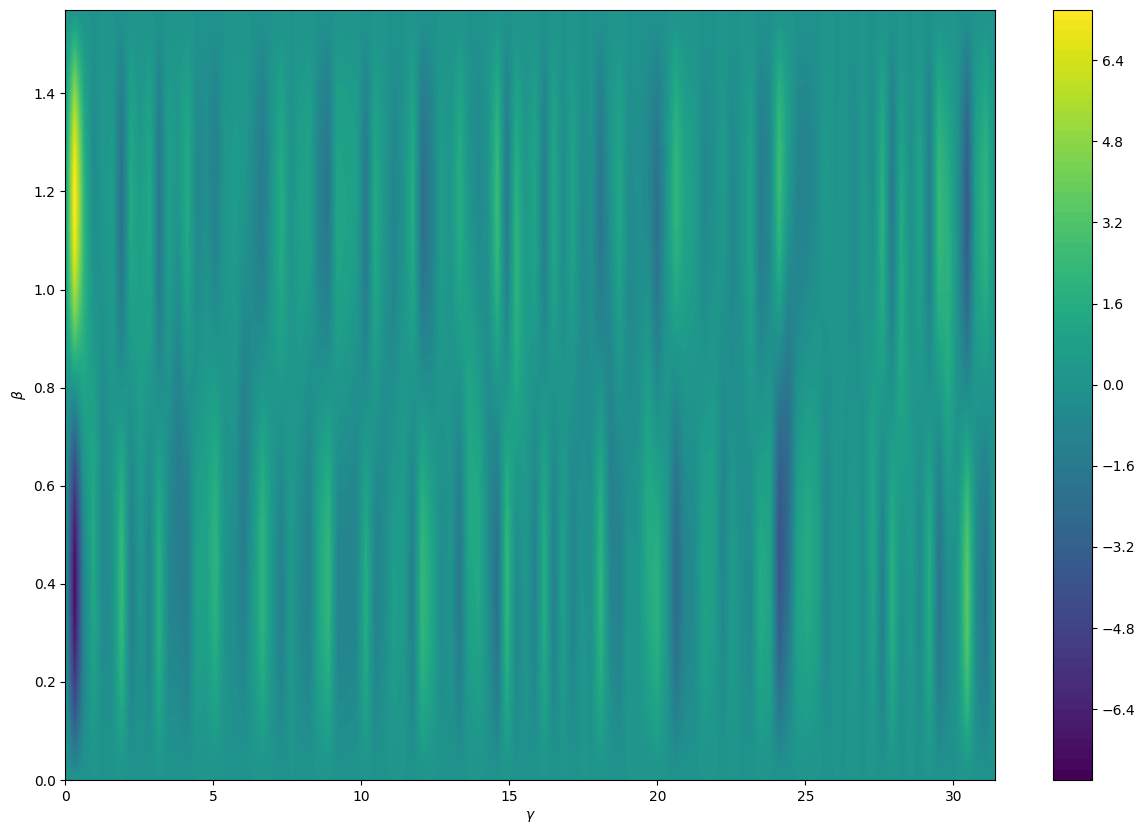

In [23]:
plt.contourf(cost_landscape_std, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

#plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()
plt.savefig("cost_landscape_sigma={}.png".format(sigma))
plt.show()

What are the main differences between the landscapes?

### Task 2: Build script to run QAOA and solve the four instances above for a variety of optimizers (mix gradient-based and non-gradient).


In [35]:
# initialize model with default configurations
q = QAOA()

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=1600,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

q.compile(maxcut_qubo) 

q.optimize()

In [36]:
optimization_angles = np.array(q.results.intermediate['angles log'])
print(optimization_angles)

[[0.35       0.35      ]
 [0.3675     0.35      ]
 [0.35       0.3675    ]
 [0.3675     0.3325    ]
 [0.37625    0.315     ]
 [0.39375    0.315     ]
 [0.415625   0.2975    ]
 [0.424375   0.2625    ]
 [0.4528125  0.21875   ]
 [0.46375    0.245     ]
 [0.441875   0.2625    ]
 [0.450625   0.2275    ]
 [0.424375   0.28      ]
 [0.406875   0.28      ]
 [0.389375   0.28875   ]
 [0.406875   0.2625    ]
 [0.398125   0.25375   ]
 [0.389375   0.28      ]
 [0.398125   0.275625  ]
 [0.398125   0.258125  ]
 [0.406875   0.245     ]
 [0.4003125  0.26796875]
 [0.4090625  0.27234375]
 [0.40085937 0.26167969]
 [0.39429687 0.26714844]
 [0.39744141 0.26598633]
 [0.39689453 0.27227539]
 [0.39986816 0.26432861]
 [0.39699707 0.26234619]
 [0.39948364 0.26656311]
 [0.4019104  0.2649054 ]
 [0.40229492 0.2626709 ]
 [0.40018646 0.26559006]
 [0.39814423 0.26501328]
 [0.39908577 0.26498631]
 [0.39940407 0.26624775]
 [0.39975214 0.2648084 ]
 [0.40085283 0.26541215]
 [0.39952754 0.26509277]
 [0.39909321 0.26431111]


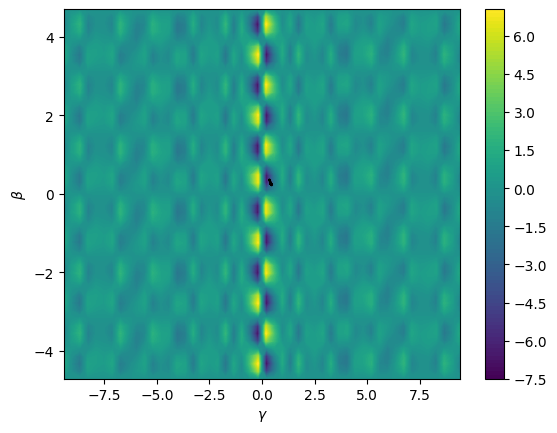

In [37]:
plt.contourf(cost_landscape_std, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

#plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()
#plt.savefig("cost_landscape_sigma={}.png".format(sigma))


plt.plot(optimization_angles[:, 0], optimization_angles[:, 1], '-', color='black',  )  


plt.show()

In [44]:
q.results.intermediate['intermediate cost'][-1]

-8.115938203279192

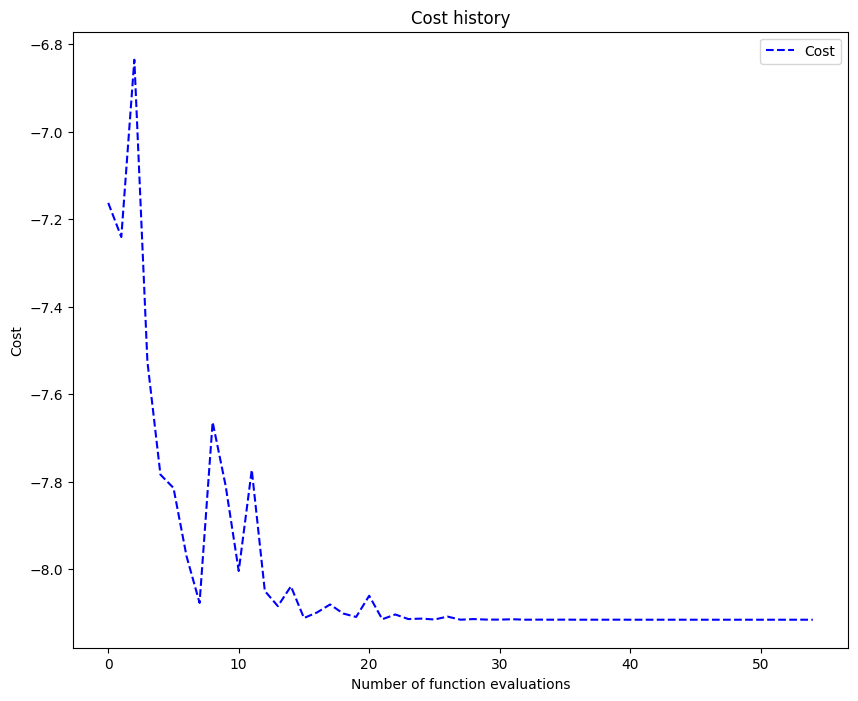

In [38]:
q.results.plot_cost()


In [42]:
q.results.most_probable_states['bitstring_energy']

-15.252028050261698

Use the QAOA result object to extract the optimization trajectories and plot them on the analytical landscapes

### Task 3: Use ground_state_hamiltonian() function from OQ to obtain the exact solution to the instances

In [39]:
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(cost_hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -15.252028050261698, Solution: ['100111011100', '011000100011']
